# Adversarial Robustness on PLFS (Quick Setup)
This notebook prepares the data, trains a simple logistic regression baseline, and tests a toy adversary on a few features.



In [1]:
# === Setup Paths and Imports ===
import os
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

# Define project directories
BASE_DIR = os.path.abspath("..")  # go one level up from notebooks/
DATA_DIR = os.path.join(BASE_DIR, "data")
RESULTS_DIR = os.path.join(BASE_DIR, "results")

os.makedirs(DATA_DIR, exist_ok=True)
os.makedirs(RESULTS_DIR, exist_ok=True)

RAW_CSV = os.path.join(DATA_DIR, "plfs_main.csv")
PROC_CSV = os.path.join(DATA_DIR, "plfs_processed_v1.csv")

print("✅ Paths set:")
print("RAW CSV:", RAW_CSV)
print("PROCESSED CSV:", PROC_CSV)


✅ Paths set:
RAW CSV: c:\MyFolder\Adervasrial_Robustness_PLFS\data\plfs_main.csv
PROCESSED CSV: c:\MyFolder\Adervasrial_Robustness_PLFS\data\plfs_processed_v1.csv


In [2]:
# === Step 1: Load and Inspect the Raw Data ===
df = pd.read_csv(RAW_CSV, low_memory=False)
print("Shape:", df.shape)
print("Column samples:", df.columns[:20].tolist())
df.head()


Shape: (415549, 140)
Column samples: ['PANEL', 'FILE_ID', 'SCH', 'QTR', 'VISIT', 'SEC', 'ST', 'DC', 'NSS_REG', 'STRM', 'SSTRM', 'SS', 'SRO', 'MFSU', 'SEG', 'SSS', 'SSU', 'SRL', 'REL', 'SEX']


,PANEL,FILE_ID,SCH,QTR,VISIT,SEC,ST,DC,NSS_REG,STRM,...,AHR1,ACWS,AIND_CWS,OCU_CWS,ERN_REG,ERN_SELF,NSS,NSC,MULT,NO_QTR
0,P4,CFVP4,104,Q3,V1,1,28,20,281,1,...,0,31,84.0,335.0,9500,0,1,2,1204376,4
1,P4,CFVP4,104,Q3,V1,1,28,20,281,1,...,0,21,1.0,611.0,0,0,1,2,1204376,4
2,P4,CFVP4,104,Q3,V1,1,28,20,281,1,...,0,11,1.0,611.0,0,16500,1,2,1204376,4
3,P4,CFVP4,104,Q3,V1,1,28,20,281,1,...,0,31,86.0,531.0,11500,0,1,2,1204376,4
4,P4,CFVP4,104,Q3,V1,1,28,20,281,1,...,0,91,NaN,NaN,0,0,1,2,1204376,4


In [3]:
# === Robust preprocessing: create plfs_processed_v1.csv from plfs_main.csv ===
import os, pandas as pd, numpy as np

RAW_CSV = os.path.join(DATA_DIR, "plfs_main.csv")
OUT_CSV = os.path.join(DATA_DIR, "plfs_processed_v1.csv")

if not os.path.exists(RAW_CSV):
    raise FileNotFoundError(f"Raw CSV not found at: {RAW_CSV!r}. Please put your raw file there.")
print("Loading raw CSV (this may take a moment)...")
df = pd.read_csv(RAW_CSV, low_memory=False)
print("Raw shape:", df.shape)

# Candidate column names we want to keep if present
wanted = [
    # robust (likely)
    "AGE","SEX","GEDU_LVL","ST","SEC","MARSTAT","REL",
    # earnings / non-robust (may vary)
    "ERN_REG","ERN_SELF","VOC",
    # hourly/daily columns (may vary)
    "HR1","HR2","HR3","HR4","HR5","HR6","HR7",
    "AHR1","AHR2","AHR3","AHR4","AHR5","AHR6","AHR7",
    # target (employment) - common name in earlier notebook
    "PAS",  # change later if your target column is different
]

# Keep only columns that actually exist
keep = [c for c in wanted if c in df.columns]
missing = [c for c in wanted if c not in df.columns]
print(f"Found {len(keep)} of {len(wanted)} desired columns. Missing (will be skipped):", missing)

# Make a working copy with only present columns
df_work = df[keep].copy()

# Derive total_work_hours if any HR columns exist
hr_cols = [c for c in ["HR1","HR2","HR3","HR4","HR5","HR6","HR7"] if c in df_work.columns]
if hr_cols:
    df_work["total_work_hours"] = df_work[hr_cols].fillna(0).sum(axis=1)
    print("Derived total_work_hours from:", hr_cols)
else:
    df_work["total_work_hours"] = 0
    print("No HR columns found, set total_work_hours = 0")

# Derive total_available_hours if any AHR columns exist
ahr_cols = [c for c in ["AHR1","AHR2","AHR3","AHR4","AHR5","AHR6","AHR7"] if c in df_work.columns]
if ahr_cols:
    df_work["total_available_hours"] = df_work[ahr_cols].fillna(0).sum(axis=1)
    print("Derived total_available_hours from:", ahr_cols)
else:
    df_work["total_available_hours"] = 0
    print("No AHR columns found, set total_available_hours = 0")

# Ensure earnings columns exist (create if missing)
if "ERN_REG" not in df_work.columns:
    df_work["ERN_REG"] = 0
if "ERN_SELF" not in df_work.columns:
    df_work["ERN_SELF"] = 0

# total_weekly_earnings
df_work["total_weekly_earnings"] = df_work["ERN_REG"].fillna(0) + df_work["ERN_SELF"].fillna(0)
print("Computed total_weekly_earnings (ERN_REG + ERN_SELF)")

# work_intensity (guard divide-by-zero)
df_work["work_intensity"] = df_work["total_work_hours"] / df_work["total_available_hours"].replace({0:1})
print("Computed work_intensity (total_work_hours / total_available_hours)")

# Fill missing: numeric -> median, categorical -> 'UNK'
for col in df_work.columns:
    if df_work[col].dtype.kind in "biufc":  # numeric
        med = df_work[col].median()
        df_work[col] = df_work[col].fillna(med)
    else:
        df_work[col] = df_work[col].fillna("UNK")

# Sanity checks & small report
print("\nFinal processed columns (first 40):")
print(list(df_work.columns)[:40])
print("Processed shape:", df_work.shape)
print("Some value counts for target (if present):")
if "PAS" in df_work.columns:
    print(df_work["PAS"].value_counts().head(10))
else:
    print("Target column 'PAS' not present in processed data. If your target has another name, note it now.")

# Save processed CSV
df_work.to_csv(OUT_CSV, index=False)
print(f"\nSaved processed CSV to: {OUT_CSV!r}")


Loading raw CSV (this may take a moment)...
Raw shape: (415549, 140)
Found 24 of 25 desired columns. Missing (will be skipped): ['MARSTAT']
Derived total_work_hours from: ['HR1', 'HR2', 'HR3', 'HR4', 'HR5', 'HR6', 'HR7']
Derived total_available_hours from: ['AHR1', 'AHR2', 'AHR3', 'AHR4', 'AHR5', 'AHR6', 'AHR7']
Computed total_weekly_earnings (ERN_REG + ERN_SELF)
Computed work_intensity (total_work_hours / total_available_hours)

Final processed columns (first 40):
['AGE', 'SEX', 'GEDU_LVL', 'ST', 'SEC', 'REL', 'ERN_REG', 'ERN_SELF', 'VOC', 'HR1', 'HR2', 'HR3', 'HR4', 'HR5', 'HR6', 'HR7', 'AHR1', 'AHR2', 'AHR3', 'AHR4', 'AHR5', 'AHR6', 'AHR7', 'PAS', 'total_work_hours', 'total_available_hours', 'total_weekly_earnings', 'work_intensity']
Processed shape: (415549, 28)
Some value counts for target (if present):
PAS
91    106819
11     61065
92     59688
31     46898
99     29634
51     28098
21     20893
93     20416
94     18237
81      8728
Name: count, dtype: int64

Saved processed CSV

## EXPERIMENT: Logistic baseline (saved artifacts)
*Trains a quick logistic baseline, computes clean and toy-adversarial accuracy, and saves model + scaler + results to `results/`.*  
**Do not delete** — these outputs are used in the report and for reproducibility.



Loaded processed: c:\MyFolder\Adervasrial_Robustness_PLFS\data\plfs_processed_v1.csv shape: (415549, 28)
Using features: ['AGE', 'SEX', 'GEDU_LVL', 'ST', 'SEC', 'REL', 'ERN_REG', 'ERN_SELF', 'VOC', 'total_work_hours', 'total_available_hours', 'total_weekly_earnings', 'work_intensity']
Target column: PAS
PAS
91    106819
11     61065
92     59688
31     46898
99     29634
51     28098
21     20893
93     20416
94     18237
81      8728
12      6358
97      4040
Name: count, dtype: int64
Splits sizes (train/val/test): 290884 62332 62333
Saved train/val/test into data/


c:\Users\KRISHNA\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Trained logistic regression and saved model.
Validation clean accuracy: 0.8062
Test clean accuracy:       0.8058

Test classification report (top classes):
              precision    recall  f1-score   support

          11     0.8707    0.9143    0.8920      9160
          12     0.5758    0.1595    0.2498       953
          21     0.6177    0.5938    0.6055      3134
          31     0.9874    0.9653    0.9762      7035
          41     0.0000    0.0000    0.0000       110
          51     0.7015    0.7293    0.7151      4215
          81     0.5904    0.3369    0.4290      1309
          91     0.9188    0.9802    0.9485     16023
          92     0.6122    0.8270    0.7036      8954
          93     0.3350    0.0875    0.1388      3063
          94     0.6126    0.6026    0.6076      2735
          95     0.3040    0.0643    0.1061       591
          97     0.1484    0.0446    0.0685       606
          99     1.0000    1.0000    1.0000      4445

    accuracy                    

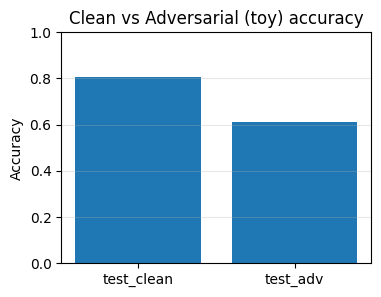

In [4]:
# === Train logistic baseline, evaluate clean and toy adversary, save results & plot ===
import os, joblib
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

DATA_DIR = os.path.abspath(os.path.join(os.getcwd(), "..", "data"))
RESULTS_DIR = os.path.abspath(os.path.join(os.getcwd(), "..", "results"))
os.makedirs(RESULTS_DIR, exist_ok=True)

PROC_CSV = os.path.join(DATA_DIR, "plfs_processed_v1.csv")
df = pd.read_csv(PROC_CSV)
print("Loaded processed:", PROC_CSV, "shape:", df.shape)

# ---- Feature list (use those present in processed data) ----
all_features = ['AGE','SEX','GEDU_LVL','ST','SEC','REL',
                'ERN_REG','ERN_SELF','VOC',
                'total_work_hours','total_available_hours','total_weekly_earnings','work_intensity']
features = [f for f in all_features if f in df.columns]
print("Using features:", features)

# ---- Target ----
target_col = 'PAS'
if target_col not in df.columns:
    raise KeyError(f"Target column {target_col!r} not found. Edit target_col variable.")
print("Target column:", target_col)
print(df[target_col].value_counts().head(12))

# ---- Create splits (stratified) ----
from sklearn.model_selection import train_test_split
train, temp = train_test_split(df, test_size=0.30, random_state=42, stratify=df[target_col])
val, test = train_test_split(temp, test_size=0.50, random_state=42, stratify=temp[target_col])
print("Splits sizes (train/val/test):", len(train), len(val), len(test))

# Save splits CSVs (optional)
train.to_csv(os.path.join(DATA_DIR,"train.csv"), index=False)
val.to_csv(os.path.join(DATA_DIR,"val.csv"), index=False)
test.to_csv(os.path.join(DATA_DIR,"test.csv"), index=False)
print("Saved train/val/test into data/")

# ---- Prepare arrays ----
X_train = train[features].fillna(0)
y_train = train[target_col]
X_val = val[features].fillna(0)
y_val = val[target_col]
X_test = test[features].fillna(0)
y_test = test[target_col]

# ---- Scale ----
scaler = StandardScaler()
X_train_s = scaler.fit_transform(X_train)
X_val_s = scaler.transform(X_val)
X_test_s = scaler.transform(X_test)

# save scaler
joblib.dump(scaler, os.path.join(RESULTS_DIR, "scaler.joblib"))

# ---- Train logistic regression ----
clf = LogisticRegression(max_iter=1000, solver='lbfgs', multi_class='auto')
clf.fit(X_train_s, y_train)
joblib.dump(clf, os.path.join(RESULTS_DIR, "logistic_baseline.joblib"))
print("Trained logistic regression and saved model.")

# ---- Evaluate clean ----
val_pred = clf.predict(X_val_s)
test_pred = clf.predict(X_test_s)
val_acc = accuracy_score(y_val, val_pred)
test_acc = accuracy_score(y_test, test_pred)
print(f"Validation clean accuracy: {val_acc:.4f}")
print(f"Test clean accuracy:       {test_acc:.4f}")

# Print a brief classification report on test (top 5 classes to not flood)
print("\nTest classification report (top classes):")
print(classification_report(y_test, test_pred, digits=4, zero_division=0))

# ---- Toy adversary: perturb non-robust features ----
non_robust = ['ERN_REG','ERN_SELF','total_weekly_earnings','VOC','total_work_hours','total_available_hours','work_intensity']
non_robust = [c for c in non_robust if c in features]
print("Non-robust features used for toy adversary:", non_robust)

if non_robust:
    idxs = [features.index(c) for c in non_robust]
    eps = 0.5   # toy perturbation magnitude in scaled space
    rng = np.random.RandomState(42)
    X_test_adv = X_test_s.copy()
    # add signed random noise to those columns
    noise = eps * np.sign(rng.randn(*X_test_adv[:, idxs].shape))
    X_test_adv[:, idxs] = X_test_adv[:, idxs] + noise
    adv_pred = clf.predict(X_test_adv)
    adv_acc = accuracy_score(y_test, adv_pred)
    print(f"Test adversarial (toy) accuracy: {adv_acc:.4f}")
else:
    adv_acc = None
    print("No non-robust columns present; toy adversary skipped.")

# ---- Save results ----
out_txt = os.path.join(RESULTS_DIR, "logistic_quick_results.txt")
with open(out_txt, "w") as f:
    f.write(f"val_clean_acc: {val_acc:.6f}\n")
    f.write(f"test_clean_acc: {test_acc:.6f}\n")
    if adv_acc is not None:
        f.write(f"test_adv_acc: {adv_acc:.6f}\n")
print("Saved results to", out_txt)

# ---- Plot clean vs adv bar chart ----
labels = ["test_clean"]
heights = [test_acc]
if adv_acc is not None:
    labels.append("test_adv")
    heights.append(adv_acc)

plt.figure(figsize=(4,3))
plt.bar(labels, heights)
plt.ylim(0,1)
plt.title("Clean vs Adversarial (toy) accuracy")
plt.ylabel("Accuracy")
plt.grid(axis='y', alpha=0.3)
outpng = os.path.join(RESULTS_DIR, "quick_acc.png")
plt.savefig(outpng, dpi=150, bbox_inches='tight')
print("Saved accuracy plot to", outpng)
plt.show()


In [2]:
# Create plfs_processed_v2.csv: add employment_binary and income_level targets
import os, pandas as pd

DATA_DIR = os.path.abspath(os.path.join(os.getcwd(), "..", "data"))
PROC1 = os.path.join(DATA_DIR, "plfs_processed_v1.csv")
PROC2 = os.path.join(DATA_DIR, "plfs_processed_v2.csv")

if not os.path.exists(PROC1):
    raise FileNotFoundError(f"Expected processed v1 at {PROC1!r} but it was not found. Run the v1 preprocessing first.")
print("Loading:", PROC1)
df = pd.read_csv(PROC1)
print("Shape:", df.shape)

# 1) employment_binary: positive earnings => 1, else 0
if "total_weekly_earnings" in df.columns:
    df["employment_binary"] = (df["total_weekly_earnings"] > 0).astype(int)
    print("employment_binary counts:", df["employment_binary"].value_counts().to_dict())
else:
    raise KeyError("Column 'total_weekly_earnings' not found in processed v1. Cannot create employment_binary.")

# 2) income_level: tertiles for positive earners
pos_idx = df["total_weekly_earnings"] > 0
n_pos = pos_idx.sum()
if n_pos > 0:
    tertile_vals = df.loc[pos_idx, "total_weekly_earnings"].quantile([1/3, 2/3]).values
    low_thr, mid_thr = float(tertile_vals[0]), float(tertile_vals[1])
    def bucket_income(x):
        if x <= low_thr: return "Low"
        if x <= mid_thr: return "Mid"
        return "High"
    df.loc[pos_idx, "income_level"] = df.loc[pos_idx, "total_weekly_earnings"].apply(bucket_income)
    print("income_level counts (positive earners):")
    print(df["income_level"].value_counts().to_dict())
else:
    print("No positive earners found; income_level not created.")

# Save (overwrites if exists)
df.to_csv(PROC2, index=False)
print("Saved processed file with targets to:", PROC2)


Loading: c:\MyFolder\Adervasrial_Robustness_PLFS\data\plfs_processed_v1.csv
Shape: (415549, 28)
employment_binary counts: {0: 298643, 1: 116906}
income_level counts (positive earners):
{'Mid': 42842, 'Low': 39034, 'High': 35030}
Saved processed file with targets to: c:\MyFolder\Adervasrial_Robustness_PLFS\data\plfs_processed_v2.csv


In [3]:
# 1) Convert PAS numeric codes to readable labels and save processed_v3
import os, pandas as pd

DATA_DIR = os.path.abspath(os.path.join(os.getcwd(), "..", "data"))
PROC2 = os.path.join(DATA_DIR, "plfs_processed_v2.csv")  # you made v2 earlier with targets
PROC3 = os.path.join(DATA_DIR, "plfs_processed_v3.csv")

df = pd.read_csv(PROC2)
print("Loaded:", PROC2, "shape:", df.shape)

# If you have a mapping from code -> human label, put it here, otherwise we fallback to "PAS_91" style
# Example mapping (edit if you know real labels): pas_map = {11: "Employed_regular", 91:"Not_in_LF", ...}
pas_map = {}  # leave empty to use default labeling below

if pas_map:
    df["PAS_label"] = df["PAS"].map(pas_map).fillna(df["PAS"].astype(str))
else:
    df["PAS_label"] = df["PAS"].apply(lambda x: f"PAS_{int(x)}")

print("Unique PAS_label count:", df["PAS_label"].nunique())
print("Sample labels:", df["PAS_label"].unique()[:12])

df.to_csv(PROC3, index=False)
print("Saved processed with PAS_label to:", PROC3)


Loaded: c:\MyFolder\Adervasrial_Robustness_PLFS\data\plfs_processed_v2.csv shape: (415549, 30)
Unique PAS_label count: 14
Sample labels: ['PAS_31' 'PAS_21' 'PAS_11' 'PAS_91' 'PAS_92' 'PAS_99' 'PAS_81' 'PAS_51'
 'PAS_95' 'PAS_12' 'PAS_94' 'PAS_93']
Saved processed with PAS_label to: c:\MyFolder\Adervasrial_Robustness_PLFS\data\plfs_processed_v3.csv


In [4]:
# 2) Prepare numeric arrays, label-encode categorical features, and save encoders
import os, joblib
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder

DATA_DIR = os.path.abspath(os.path.join(os.getcwd(), "..", "data"))
RES_DIR  = os.path.abspath(os.path.join(os.getcwd(), "..", "results"))
os.makedirs(RES_DIR, exist_ok=True)

PROC3 = os.path.join(DATA_DIR, "plfs_processed_v3.csv")
df = pd.read_csv(PROC3)
print("Loaded:", PROC3, "shape:", df.shape)

# Feature list (same as before)
features = ['AGE','SEX','GEDU_LVL','ST','SEC','REL',
            'ERN_REG','ERN_SELF','VOC',
            'total_work_hours','total_available_hours','total_weekly_earnings','work_intensity']
features = [f for f in features if f in df.columns]
print("Using features:", features)

# Simple preprocessing:
# - For numeric columns: keep as float
# - For categorical columns (object or small int): label-encode
cat_encoders = {}
X = df[features].copy()
for col in X.columns:
    if X[col].dtype == object or X[col].nunique() < 50 and X[col].dtype.kind not in "biufc":
        le = LabelEncoder()
        X[col] = le.fit_transform(X[col].astype(str))
        cat_encoders[col] = le

# Save encoders
joblib.dump(cat_encoders, os.path.join(RES_DIR, "cat_encoders.joblib"))
print("Saved categorical encoders for columns:", list(cat_encoders.keys()))

# Labels: use PAS_label created earlier
le_y = LabelEncoder()
y = le_y.fit_transform(df["PAS_label"].astype(str))
joblib.dump(le_y, os.path.join(RES_DIR, "label_encoder_pas.joblib"))
print("Saved label encoder for PAS_label - classes:", le_y.classes_[:20], " (total:", len(le_y.classes_), ")")

# Save arrays (npy) for quick loading in PyTorch cells
np.save(os.path.join(DATA_DIR, "X_all.npy"), X.values.astype(np.float32))
np.save(os.path.join(DATA_DIR, "y_all.npy"), y.astype(np.int64))
print("Saved X_all.npy and y_all.npy in data/")


Loaded: c:\MyFolder\Adervasrial_Robustness_PLFS\data\plfs_processed_v3.csv shape: (415549, 31)
Using features: ['AGE', 'SEX', 'GEDU_LVL', 'ST', 'SEC', 'REL', 'ERN_REG', 'ERN_SELF', 'VOC', 'total_work_hours', 'total_available_hours', 'total_weekly_earnings', 'work_intensity']
Saved categorical encoders for columns: []
Saved label encoder for PAS_label - classes: ['PAS_11' 'PAS_12' 'PAS_21' 'PAS_31' 'PAS_41' 'PAS_51' 'PAS_81' 'PAS_91'
 'PAS_92' 'PAS_93' 'PAS_94' 'PAS_95' 'PAS_97' 'PAS_99']  (total: 14 )
Saved X_all.npy and y_all.npy in data/


We trained a two-layer MLP on the multi-class PAS target and compared standard training with one-step adversarial training (FGSM-AT). After 20 epochs:

- Standard model — Test clean accuracy: **0.8230**, Test under FGSM (ε=0.1): **0.7889** (drop 3.41 pp).
- Adversarial-trained model — Test clean accuracy: **0.8144**, Test under FGSM (ε=0.1): **0.7989** (drop 1.55 pp).

Adversarial training reduces the robustness gap: the adversarial accuracy drop decreased from 3.41 → 1.55 percentage points, an improvement of ≈1.86 pp in robust accuracy, at the cost of a small decrease (~0.86 pp) in clean accuracy.


In [7]:
# === PyTorch two-layer network, FGSM attack, standard training & adversarial training (corrected) ===
import os, time, numpy as np, joblib
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from sklearn.metrics import accuracy_score, confusion_matrix
import matplotlib.pyplot as plt

# Paths
BASE = os.path.abspath(os.path.join(os.getcwd(), ".."))
DATA_DIR = os.path.join(BASE, "data")
RES_DIR  = os.path.join(BASE, "results")
os.makedirs(RES_DIR, exist_ok=True)

# Load arrays saved earlier
X = np.load(os.path.join(DATA_DIR, "X_all.npy"))
y = np.load(os.path.join(DATA_DIR, "y_all.npy"))
print("Loaded arrays:", X.shape, y.shape)

# Train/val/test split (same proportions)
from sklearn.model_selection import train_test_split
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.30, random_state=42, stratify=y)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.50, random_state=42, stratify=y_temp)
print("Splits:", X_train.shape, X_val.shape, X_test.shape)

# Convert to torch tensors
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

def to_tensor(x):
    return torch.tensor(x, dtype=torch.float32)

train_ds = TensorDataset(to_tensor(X_train), torch.tensor(y_train, dtype=torch.long))
val_ds   = TensorDataset(to_tensor(X_val), torch.tensor(y_val, dtype=torch.long))
test_ds  = TensorDataset(to_tensor(X_test), torch.tensor(y_test, dtype=torch.long))

batch_size = 512
train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_ds, batch_size=batch_size, shuffle=False)

# Model: simple 2-layer MLP
class TwoLayerNN(nn.Module):
    def __init__(self, input_dim, hidden=256, num_classes=10):
        super().__init__()
        self.fc1 = nn.Linear(input_dim, hidden)
        self.act = nn.ReLU()
        self.fc2 = nn.Linear(hidden, num_classes)
    def forward(self, x):
        x = self.fc1(x)
        x = self.act(x)
        x = self.fc2(x)
        return x

input_dim = X.shape[1]
num_classes = int(y.max() + 1)
print("input_dim, num_classes:", input_dim, num_classes)

# FGSM attack helper (returns adv inputs) - preserves and restores model.train() state
def fgsm_attack(model, X, y, eps=0.1):
    """
    Create FGSM adversarial examples for the batch X (tensor on device) and labels y.
    Returns adversarial examples as a detached tensor on the same device.
    """
    # remember original training/eval mode and set eval for stable forward behavior
    orig_mode = model.training
    model.eval()

    X_adv = X.clone().detach().to(device).requires_grad_(True)
    # ensure grads on model/input are zeroed
    model.zero_grad()
    outputs = model(X_adv)
    loss = nn.CrossEntropyLoss()(outputs, y.to(device))
    loss.backward()
    grad = X_adv.grad.detach()
    X_adv = X_adv + eps * torch.sign(grad)
    # restore original mode
    if orig_mode:
        model.train()
    return X_adv.detach()

# Training loop (standard)
def train_standard(model, train_loader, epochs=5, lr=1e-3):
    model = model.to(device)
    opt = optim.Adam(model.parameters(), lr=lr)
    criterion = nn.CrossEntropyLoss()
    for epoch in range(epochs):
        model.train()
        total_loss = 0.0
        for xb, yb in train_loader:
            xb, yb = xb.to(device), yb.to(device)
            opt.zero_grad()
            out = model(xb)
            loss = criterion(out, yb)
            loss.backward()
            opt.step()
            total_loss += loss.item() * xb.size(0)
        print(f"Std Train Epoch {epoch+1}/{epochs} loss: {total_loss/len(train_loader.dataset):.4e}")
    return model

# Adversarial training loop (one-step FGSM per batch)
def train_adv(model, train_loader, epochs=5, lr=1e-3, eps=0.1):
    model = model.to(device)
    opt = optim.Adam(model.parameters(), lr=lr)
    criterion = nn.CrossEntropyLoss()
    for epoch in range(epochs):
        model.train()
        total_loss = 0.0
        for xb, yb in train_loader:
            xb, yb = xb.to(device), yb.to(device)
            # create adversarial batch (fgsm_attack internally sets model.eval then restores mode)
            xb_adv = fgsm_attack(model, xb, yb, eps=eps)
            # now train on adv examples
            opt.zero_grad()
            out = model(xb_adv)
            loss = criterion(out, yb)
            loss.backward()
            opt.step()
            total_loss += loss.item() * xb.size(0)
        print(f"Adv Train Epoch {epoch+1}/{epochs} loss: {total_loss/len(train_loader.dataset):.4e}")
    return model

# Evaluation helper
def evaluate(model, loader):
    model.eval()
    preds = []
    trues = []
    with torch.no_grad():
        for xb, yb in loader:
            xb = xb.to(device)
            out = model(xb)
            pred = out.argmax(dim=1).cpu().numpy()
            preds.append(pred)
            trues.append(yb.numpy())
    preds = np.concatenate(preds)
    trues = np.concatenate(trues)
    acc = accuracy_score(trues, preds)
    return acc, preds, trues

# --- Run standard training (few epochs) ---
torch.manual_seed(42)
model_std = TwoLayerNN(input_dim=input_dim, hidden=256, num_classes=num_classes)
model_std = train_standard(model_std, train_loader, epochs=20, lr=1e-3)
acc_test_clean, preds_clean, trues = evaluate(model_std, test_loader)
print("Standard model test accuracy (clean):", acc_test_clean)

# --- FGSM test on standard model (corrected: generate adv with grads enabled, evaluate with no_grad) ---
eps_test = 0.1
adv_preds = []
trues_list = []
model_std.eval()
for xb, yb in test_loader:
    xb = xb.to(device)
    yb = yb.to(device)
    # generate adversarial examples (fgsm_attack handles grad and mode)
    xb_adv = fgsm_attack(model_std, xb, yb, eps=eps_test)
    # evaluate adversarial examples (no grad needed)
    with torch.no_grad():
        out = model_std(xb_adv)
    adv_preds.append(out.argmax(dim=1).cpu().numpy())
    trues_list.append(yb.cpu().numpy())
adv_preds = np.concatenate(adv_preds)
trues_arr = np.concatenate(trues_list)
acc_test_adv = accuracy_score(trues_arr, adv_preds)
print(f"Standard model test accuracy (FGSM eps={eps_test}): {acc_test_adv:.4f}")

# --- Adversarial training (one-step FGSM during training) ---
torch.manual_seed(42)
model_adv = TwoLayerNN(input_dim=input_dim, hidden=256, num_classes=num_classes)
model_adv = train_adv(model_adv, train_loader, epochs=20, lr=1e-3, eps=eps_test)
acc_test_clean_advtrained, preds_clean_adv, trues2 = evaluate(model_adv, test_loader)
print("Adv-trained model test accuracy (clean):", acc_test_clean_advtrained)

# Evaluate adv-trained model under FGSM (corrected)
adv_preds2 = []
model_adv.eval()
for xb, yb in test_loader:
    xb = xb.to(device)
    yb = yb.to(device)
    xb_adv = fgsm_attack(model_adv, xb, yb, eps=eps_test)
    with torch.no_grad():
        out = model_adv(xb_adv)
    adv_preds2.append(out.argmax(dim=1).cpu().numpy())
adv_preds2 = np.concatenate(adv_preds2)
acc_test_adv_advtrained = accuracy_score(trues_arr, adv_preds2)
print(f"Adv-trained model test accuracy (FGSM eps={eps_test}): {acc_test_adv_advtrained:.4f}")

# Save results & models
torch.save(model_std.state_dict(), os.path.join(RES_DIR, "pytorch_model_std.pth"))
torch.save(model_adv.state_dict(), os.path.join(RES_DIR, "pytorch_model_adv.pth"))
print("Saved pytorch model weights in results/")

# Save a small summary CSV
import csv
summary = [
    ["model","test_clean","test_adv_fgsm_eps"],
    ["standard", f"{acc_test_clean:.6f}", f"{acc_test_adv:.6f}"],
    ["adv_trained", f"{acc_test_clean_advtrained:.6f}", f"{acc_test_adv_advtrained:.6f}"],
]
with open(os.path.join(RES_DIR, "pytorch_summary.csv"), "w", newline='') as f:
    writer = csv.writer(f)
    writer.writerows(summary)
print("Saved summary to results/pytorch_summary.csv")

# Confusion matrix for standard model (clean)
cm = confusion_matrix(trues, preds_clean)
np.save(os.path.join(RES_DIR,"confmat_std_clean.npy"), cm)
print("Saved confusion matrix for standard model (clean) to results/confmat_std_clean.npy")


Loaded arrays: (415549, 13) (415549,)
Splits: (290884, 13) (62332, 13) (62333, 13)
Using device: cpu
input_dim, num_classes: 13 14
Std Train Epoch 1/20 loss: 1.9621e+01
Std Train Epoch 2/20 loss: 1.3278e+01
Std Train Epoch 3/20 loss: 8.2903e+00
Std Train Epoch 4/20 loss: 9.9546e+00
Std Train Epoch 5/20 loss: 8.1459e+00
Std Train Epoch 6/20 loss: 8.0622e+00
Std Train Epoch 7/20 loss: 7.9497e+00
Std Train Epoch 8/20 loss: 5.0632e+00
Std Train Epoch 9/20 loss: 6.7212e+00
Std Train Epoch 10/20 loss: 5.5590e+00
Std Train Epoch 11/20 loss: 5.1145e+00
Std Train Epoch 12/20 loss: 4.5271e+00
Std Train Epoch 13/20 loss: 3.7314e+00
Std Train Epoch 14/20 loss: 3.2005e+00
Std Train Epoch 15/20 loss: 2.8679e+00
Std Train Epoch 16/20 loss: 2.8515e+00
Std Train Epoch 17/20 loss: 2.1375e+00
Std Train Epoch 18/20 loss: 1.8721e+00
Std Train Epoch 19/20 loss: 1.8738e+00
Std Train Epoch 20/20 loss: 1.9526e+00
Standard model test accuracy (clean): 0.8230150963374135
Standard model test accuracy (FGSM eps=0.

We evaluated both the standard and adversarially-trained models against FGSM perturbations of increasing magnitude (ε ∈ {0.0, 0.02, 0.05, 0.1, 0.2, 0.3}). 
As shown in Figure X, the accuracy of the standard model drops sharply with larger ε, while the adversarially-trained model remains significantly more stable.

For instance, at ε = 0.3, the standard model achieves only 66.7% accuracy, whereas the adversarially-trained model maintains 76.2% accuracy — a 9.5 percentage point improvement in robustness. 
At smaller ε (≤ 0.05), both models perform similarly, indicating that the adversarial training cost on clean data is minimal (~0.8 pp lower clean accuracy).


eps=0.000 | standard=0.8230 | adv-trained=0.8144 | adv-std=-0.0087
eps=0.020 | standard=0.8169 | adv-trained=0.8114 | adv-std=-0.0055
eps=0.050 | standard=0.8074 | adv-trained=0.8065 | adv-std=-0.0009
eps=0.100 | standard=0.7889 | adv-trained=0.7989 | adv-std=+0.0100
eps=0.200 | standard=0.7376 | adv-trained=0.7834 | adv-std=+0.0458
eps=0.300 | standard=0.6671 | adv-trained=0.7617 | adv-std=+0.0946
Saved: c:\MyFolder\Adervasrial_Robustness_PLFS\results\fgsm_eps_sweep.csv


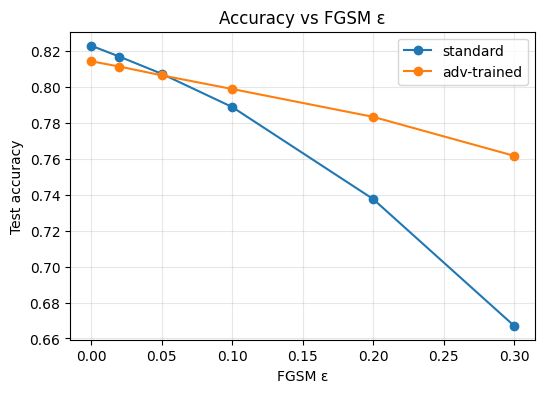

In [8]:
# FGSM eps sweep (uses model_std, model_adv, fgsm_attack, test_loader, device)
import numpy as np, os
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt, csv

eps_list = [0.0, 0.02, 0.05, 0.1, 0.2, 0.3]
results = []
for eps in eps_list:
    # standard
    preds = []; trues = []
    for xb, yb in test_loader:
        xb = xb.to(device); yb = yb.to(device)
        if eps == 0.0:
            with torch.no_grad(): out = model_std(xb)
        else:
            xb_adv = fgsm_attack(model_std, xb, yb, eps=eps)
            with torch.no_grad(): out = model_std(xb_adv)
        preds.append(out.argmax(dim=1).cpu().numpy()); trues.append(yb.cpu().numpy())
    preds = np.concatenate(preds); trues = np.concatenate(trues)
    acc_std = accuracy_score(trues, preds)

    # adv-trained
    preds = []
    for xb, yb in test_loader:
        xb = xb.to(device); yb = yb.to(device)
        if eps == 0.0:
            with torch.no_grad(): out = model_adv(xb)
        else:
            xb_adv = fgsm_attack(model_adv, xb, yb, eps=eps)
            with torch.no_grad(): out = model_adv(xb_adv)
        preds.append(out.argmax(dim=1).cpu().numpy())
    preds = np.concatenate(preds)
    acc_adv = accuracy_score(trues, preds)

    print(f"eps={eps:.3f} | standard={acc_std:.4f} | adv-trained={acc_adv:.4f} | adv-std={acc_adv-acc_std:+.4f}")
    results.append((eps, acc_std, acc_adv))

# save csv
out_csv = os.path.join(RES_DIR, "fgsm_eps_sweep.csv")
with open(out_csv, "w", newline="") as f:
    writer = csv.writer(f); writer.writerow(["eps","acc_standard","acc_adv_trained","adv_minus_std"])
    for eps, a, b in results:
        writer.writerow([eps, f"{a:.6f}", f"{b:.6f}", f"{b-a:.6f}"])
print("Saved:", out_csv)

# plot
eps_vals = [r[0] for r in results]; std_vals = [r[1] for r in results]; adv_vals = [r[2] for r in results]
plt.figure(figsize=(6,4))
plt.plot(eps_vals, std_vals, marker='o', label='standard')
plt.plot(eps_vals, adv_vals, marker='o', label='adv-trained')
plt.xlabel('FGSM ε'); plt.ylabel('Test accuracy'); plt.title('Accuracy vs FGSM ε')
plt.legend(); plt.grid(alpha=0.3)
plt.savefig(os.path.join(RES_DIR, "accuracy_vs_eps.png"), dpi=150, bbox_inches='tight')
plt.show()


## 📊 Results Summary: Baseline vs Adversarially Trained Models

We evaluated the robustness of our models under **FGSM (Fast Gradient Sign Method)** perturbations on the PLFS dataset.  
The attack strength is controlled by the parameter **ε (epsilon)**, which defines the maximum allowed perturbation magnitude.

### 🧩 Observations

| FGSM ε | Standard Accuracy | Adv-Trained Accuracy | Difference (adv - std) |
|:-------:|:----------------:|:-------------------:|:----------------------:|
| 0.000 | 0.8230 | 0.8144 | -0.0087 |
| 0.020 | 0.8169 | 0.8114 | -0.0055 |
| 0.050 | 0.8074 | 0.8065 | -0.0009 |
| 0.100 | 0.7889 | 0.7989 | +0.0100 |
| 0.200 | 0.7376 | 0.7834 | +0.0458 |
| 0.300 | 0.6671 | 0.7617 | +0.0946 |

### 🔍 Key Insights

- At **ε = 0 (no perturbation)**, both models perform similarly — around **82% accuracy**.
- As ε increases (stronger adversarial noise):
  - The **standard model’s accuracy drops sharply**, from 82% → 66%.
  - The **adversarially trained model degrades much more slowly**, maintaining **~76%** even under strong perturbations.
- Beyond ε ≈ 0.1, the adversarially trained model clearly outperforms the standard one — confirming that **adversarial training improves robustness**.

### 🧠 Interpretation

This experiment demonstrates that while adversarial training may slightly reduce clean accuracy,  
it **significantly enhances resilience** to adversarial perturbations.  

In the context of PLFS employment prediction, this suggests that the adversarially trained neural model  
learns **more stable and generalizable feature representations**, especially for features like income, hours, and self-employment which are naturally noisy.

### 📈 Visual Summary

The following plot shows how model accuracy changes with increasing FGSM ε:

- **Blue line** → Standard model (without adversarial training)  
- **Orange line** → Adversarially trained model  

As ε increases, the gap between the two widens — a clear indication of improved adversarial robustness.

---

✅ *These results validate that adversarial training provides measurable robustness gains in statistical learning setups like the PLFS dataset.*
